In [ ]:
import matplotlib as mpl
mpl.use('Agg')
from os.path import join
from matplotlib import pyplot as plt

In [79]:
import os
import numpy as np
os.environ['QT_QPA_FONTDIR']='/home/jgsanders/miniconda/envs/qiime2-2018.6/etc/fonts/conf.d/'
os.environ['QT_QPA_PLATFORM']='offscreen'

from matplotlib import cm

from skbio import TreeNode
from biom import load_table, Table

from ete3 import Tree, TextFace, TreeStyle, NodeStyle
from qiime2 import Artifact

In [2]:
% matplotlib inline

In [3]:
import subprocess

def qsub(script, environment='source activate qiime2-2018.6',
         mem=32, n=8, t='24:00:00', name='nb_qsub',
         o='/dev/null', e='/dev/null'):
    payload = '{0}; {1}'.format(environment, script)
    
    cmd = ('echo "{payload}" | '
           'qsub -o {o} -e {e} -N {name} '
           '-l nodes=1:ppn={n} -l mem={mem}gb -l '
           'walltime={t}'.format(payload=payload, o=o, e=e, n=n, name=name, mem=mem, t=t))
    
    
    ps = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    output = ps.communicate()[0]
    
    print(cmd)
    
    return(output)  

# Insertion-constrained phylogeny calculation

This notebook gives an example of insertion-constrained phylogenetic tree insertion for 16S microbial sequences. 

The motivation for microbial tree estimation using constraints derived from phylogenetic insertion is to be able to create a tree of microbial 16S sequence fragments which both 1) conforms to the higher-level topology calculated from better data, and 2) retains as much information as possible about fine-level relationships among sequences. 

This is particularly relevant to problems involving host-microbe association, as it is frequently the case that reference databases will contain a few sequences close to a group of newly-observed host-associated microbes, but not enough to reflect the total amount of host-related diversity within the clade. Consequently, newly-observed sequences will all be inserted with long branches into the same edge on the reference phylogeny.

## Example data and visualization

We'll use a small set of OTUs from a recent publication on host-associated microbes [(Amato *et al.* 2017, *ISMEJ*)](https://www.nature.com/articles/s41396-018-0175-0) to illustrate this phenomenon, and to test our method. 

In [4]:
data_dir = './phylogeny_constraint/data'
output_dir = './phylogeny_constraint/output'

In [5]:
test_otu_fp =join(data_dir, 'test_otus.fasta')
test_otu_tree_fp = join(data_dir, 'test_otus.tre')

In [6]:
!head {test_otu_fp}

>denovo0
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATGTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo1
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACTCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo10
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAAACAGGTCAGATGTGAAAGCTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo2
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTCAACTCCGGAGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo3
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACCCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG


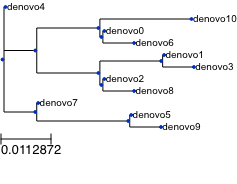

In [7]:
test_otu_tree = Tree(test_otu_tree_fp)

test_otu_tree.render("%%inline")

Now, we'll color these tips by the predominant host group in which they're found.

In [8]:
def highlight_tree(tree, leaf_colors):

    for node in tree.traverse():
        # Hide node circles
        node.img_style['size'] = 0
        if node.is_leaf():
            color = leaf_colors.get(node.name, None)
            if color:
                name_face = TextFace(node.name, fgcolor=color, fsize=10)
                node.add_face(name_face, column=0, position='branch-right')


    ts = TreeStyle()
    # ts.scale = 10
    # Disable the default tip names config
    ts.show_leaf_name = False
    ts.show_scale = False
    # Draw Tree
    return(tree.render('%%inline',  tree_style=ts))

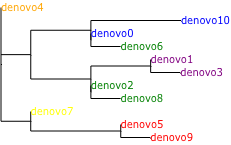

In [9]:
test_otu_tree = Tree(test_otu_tree_fp)

leaf_colors = {'denovo4': 'orange',
              'denovo7': 'yellow',
              'denovo9': 'red',
              'denovo5': 'red',
              'denovo3': 'purple',
              'denovo1': 'purple',
              'denovo8': 'green',
              'denovo2': 'green',
              'denovo10': 'blue',
              'denovo0': 'blue',
              'denovo6': 'green'}

highlight_tree(test_otu_tree, leaf_colors)

In [10]:
def highlight_tree_phyla(tree, leaf_phyla, phylum_colors):

    for node in tree.traverse():
        # Hide node circles
        node.img_style['size'] = 0
        if node.is_leaf():
            phylum = leaf_phyla.get(node.name, None)
            color = phylum_colors.get(phylum, None)
            if color:
                name_face = TextFace(node.name, fgcolor=color, fsize=10)
                node.add_face(name_face, column=0, position='branch-right')


    ts = TreeStyle()
    # ts.scale = 10
    # Disable the default tip names config
    ts.show_leaf_name = False
    ts.show_scale = False
    # Draw Tree
    return(tree.render('%%inline',  tree_style=ts))

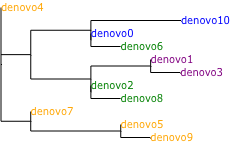

In [11]:
test_otu_tree = Tree(test_otu_tree_fp)

leaf_phyla = {'denovo4': 'p_Firmicutes',
              'denovo7': 'p_Firmicutes',
              'denovo9': 'p_Firmicutes',
              'denovo5': 'p_Firmicutes',
              'denovo3': 'p_Bacteroidetes',
              'denovo1': 'p_Bacteroidetes',
              'denovo8': 'p_Proteobacteria',
              'denovo2': 'p_Proteobacteria',
              'denovo10': 'p_Actinobacteria',
              'denovo0': 'p_Actinobacteria',
              'denovo6': 'p_Proteobacteria'}

phylum_colors = {'p_Firmicutes': 'orange',
              'p_Bacteroidetes': 'purple',
              'p_Proteobacteria': 'green',
              'p_Actinobacteria': 'blue'}

highlight_tree_phyla(test_otu_tree, leaf_phyla, phylum_colors)

Searching these squences against GreenGenes reveals only two hits, which group the two major clades, but fail to resolve any of the variation within clades.

In [12]:
# !vsearch --usearch_global {test_otu_fp} --db {data_dir}/97_otus.fasta.gz --id 0.97 --top_hits_only --blast6out -

We'll try inserting these into the GG phylogeny and see what we get out

In [13]:
test_otu_artifact_fp = join(data_dir, 'test_sequences.qza')

In [14]:
# !qiime tools import --type FeatureData[Sequence] \
# --input-format DNAFASTAFormat \
# --input-path ./phylogeny_constraint/data/test_otus.fasta \
# --output-path {test_otu_artifact_fp}

In [15]:
test_insertion_fp = join(data_dir, 'test_sequences.sepp.tre.qza')
test_placement_fp = join(data_dir, 'test_sequences.sepp.json.qza')

In [16]:
# !qiime fragment-insertion sepp \
# --i-representative-sequences ./phylogeny_constraint/data/test_sequences.qza \
# --o-tree {test_insertion_fp} --o-placements {test_placement_fp}

In [17]:
test_insertion_newick_fp = join(data_dir, 'test_sequences.sepp.tre')

In [22]:
!qiime tools export --input-path {foofp} \
--output-path test.fna \
--output-format DNAFASTAFormat

Exported ./phylogeny_constraint/data/test_sequences.qza as DNAFASTAFormat to file test.fna


In [23]:
!head test.fna

>denovo0
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATGTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo1
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACTCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo10
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAAACAGGTCAGATGTGAAAGCTCGGGGCTCAACCCCGGAACTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo2
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTCAACTCCGGAGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG
>denovo3
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAAGACAGGTCAGATGTGAAATACCGGGGCTTAACCCCGGGGCTGCATTTGAAACCGTTTTTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG


In [24]:
!qiime tools export --input-path {test_insertion_fp} \
--output-path {test_insertion_newick_fp} \
--output-format NewickFormat

Exported ./phylogeny_constraint/data/test_sequences.sepp.tre.qza as NewickFormat to file ./phylogeny_constraint/data/test_sequences.sepp.tre


In [25]:
# Importing newick tree

In [26]:
insert_tree = TreeNode.read(test_insertion_newick_fp)

In [27]:
inserted_subtree = insert_tree.lca(leaf_colors.keys())

In [28]:
inserted_subtree_fp = join(data_dir, 'test_sequences.sepp.subtree.tre')

inserted_subtree.write(inserted_subtree_fp)

'./phylogeny_constraint/data/test_sequences.sepp.subtree.tre'

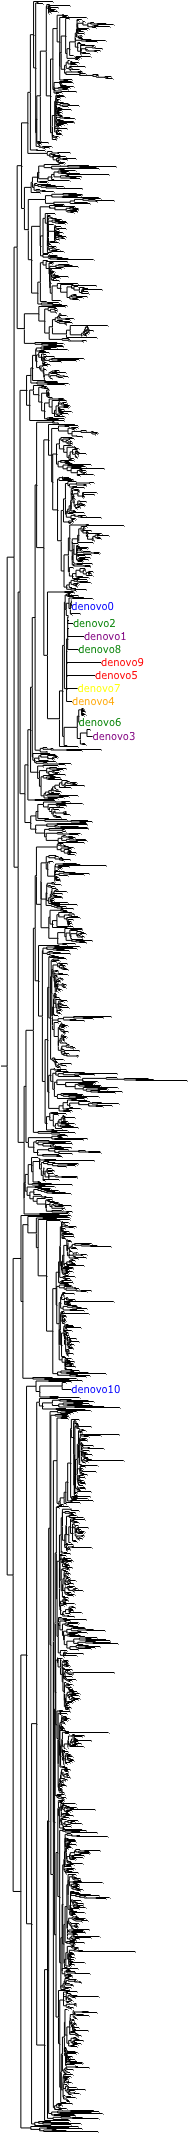

In [29]:
highlight_tree(Tree(inserted_subtree_fp), leaf_colors)

If we trim this down to just the tips we inserted, we can see how much of the internal structure has been removed in the insertion process:

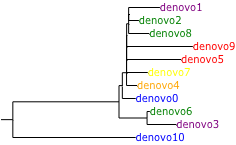

In [30]:
subtree_only = inserted_subtree.shear(leaf_colors.keys())

subtree_only_fp = join(data_dir, 'test_sequences.sepp.subtree.only.tre')

subtree_only.write(subtree_only_fp)

highlight_tree(Tree(subtree_only_fp), leaf_colors)

In [31]:
!head {subtree_only_fp}

(((((((((denovo1:0.0221287,denovo2:0.00726798):0.0,denovo8:0.0146221):0.00141544,denovo9:0.0468179):8.8363e-06,denovo5:0.0386087):3.97512e-05,denovo7:0.0149922):1.05796e-05,denovo4:0.007454):0.00299102,denovo0:0.00947843352):0.00235144,(denovo6:0.00197690352,denovo3:0.020793730000000003):0.01984514):0.07509018,denovo10:0.08689025):0.00837201;


## Collapse nodes in insertion tree

The sheared insertion tree is still bifurcating, even if many of the branches are meaningless. We'll write some code to collapse the nodes of the tree up to a given width. 

In [32]:
test_nwk = ('(((((((((denovo1:0.0221287,denovo2:0.00726798):0.0,denovo8:0.0146221)'
            ':0.00141544,denovo9:0.0468179):8.8363e-06,denovo5:0.0386087):3.97512e'
            '-05,denovo7:0.0149922):1.05796e-05,denovo4:0.007454):0.00299102,denov'
            'o0:0.00947843352):0.00235144,(denovo6:0.00197690352,denovo3:0.0207937'
            '30000000003):0.01984514):0.07509018,denovo10:0.08689025):0.00837201;\n')

exp_nwk = ('((denovo1:0.0,denovo2:0.0,denovo8:0.0,denovo9:0.0,denovo5:0.0,denovo7:0.0'
           ',denovo4:0.0,denovo0:0.0,denovo6:0.0,denovo3:0.0):0.07509018,denovo10:0.08'
           '689025):0.00837201;\n')

from io import StringIO

test_tree = TreeNode.read(StringIO(test_nwk))
exp_tree = TreeNode.read(StringIO(exp_nwk))

def collapse_nodes_to_width(in_tree, max_width=0.1, inplace=False):
    tree = in_tree.copy()
    for node in tree.postorder():
        node.width = node.get_max_distance()[0]
        
    for node in tree.postorder():
        if node.width < max_width:
            children = [x for x in node.tips()]
            for x in children:
                x.length = 0.
            node.children = children
    
    return(tree)

obs_tree = collapse_nodes_to_width(test_tree, max_width=0.1)
assert(obs_tree.write(StringIO()).getvalue() == exp_nwk)


exp_nwk_nolen = ('((denovo1,denovo2,denovo8,denovo9,denovo5,denovo7'
                 ',denovo4,denovo0,denovo6,denovo3),denovo10);\n')

def remove_branch_lengths(in_tree):
    tree = in_tree.copy()
    for node in tree.postorder():
        node.length = None
    return(tree)

obs_tree_nolen = remove_branch_lengths(exp_tree)

assert(obs_tree_nolen.write(StringIO()).getvalue() == exp_nwk_nolen)

## Run IQ-TREE with constraints

In [33]:
obs_constraint_fp = join(data_dir, 'test_sequences.sepp.subtree.only.constraint.tre')
obs_tree_nolen.write(obs_constraint_fp)

'./phylogeny_constraint/data/test_sequences.sepp.subtree.only.constraint.tre'

In [34]:
test_otu_aln_fp = join(data_dir, 'test_otus.aln.fasta')

In [214]:
%%capture
# mafft align sequences

!mafft {test_otu_fp} > {test_otu_aln_fp}

In [215]:
%%capture

# run IQ-TREE with constraints
!iqtree -nt 1 -s ./phylogeny_constraint/data/test_otus.aln.fasta \
-m TIM2+I+G -g ./phylogeny_constraint/data/test_sequences.sepp.subtree.only.constraint.tre \
-pre ./phylogeny_constraint/data/test_sequences.sepp.subtree.only.constrained

In [117]:
bad_nwk_nolen = ('(((denovo1,denovo2),denovo8),((denovo9,denovo5),denovo7'
                 ',(denovo4,denovo0))),(denovo6,(denovo3,denovo10));')

with open(join(data_dir, 'bad.constraint.tre'), 'w') as f:
    f.write(bad_nwk_nolen)

In [116]:
bad_cons = TreeNode.read(join(data_dir, 'bad.constraint.tre'))

UnrecognizedFormatError: Could not detect the format of <_io.BufferedReader name='./phylogeny_constraint/data/bad.constraint.tre'>

In [103]:
bad_cons.write(join(data_dir, 'bad.constraint.skb.tre'))

'./phylogeny_constraint/data/bad.constraint.skb.tre'

In [115]:
!cat ./phylogeny_constraint/data/bad.constraint.skb.tre

# run IQ-TREE with constraints
!iqtree -nt 1 -redo -s ./phylogeny_constraint/data/test_otus.aln.fasta \
-m TIM2+I+G -g ./phylogeny_constraint/data/bad.constraint.skb.tre \
-pre ./phylogeny_constraint/data/test_sequences.sepp.subtree.only.constrained

((((denovo1,denovo2),denovo8),((denovo9,denovo5),denovo7,(denovo4,denovo0))),(denovo6,(denovo3,denovo10)));
IQ-TREE multicore version 1.5.5 for Mac OS X 64-bit built Feb  4 2018
Copyright (c) 2011-2017 by Bui Quang Minh, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, and Arndt von Haeseler.

Host:    Jons-MacBook-2.local (AVX2, FMA3, 8 GB RAM)
Command: iqtree -nt 1 -redo -s ./phylogeny_constraint/data/test_otus.aln.fasta -m TIM2+I+G -g ./phylogeny_constraint/data/bad.constraint.skb.tre -pre ./phylogeny_constraint/data/test_sequences.sepp.subtree.only.constrained
Seed:    36288 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Wed Oct  3 12:24:15 2018
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

Reading alignment file ./phylogeny_constraint/data/test_otus.aln.fasta ... Fasta format detected
Alignment most likely contains DNA/RNA sequences
Alignment has 11 sequences with 150 columns and 17 patterns (11 informative sites, 136 constant sites)
          Gap/Ambigui

We can see that we have now recovered substantial structure within our group of sequences

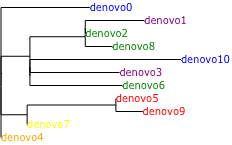

In [62]:
highlight_tree(Tree(join(data_dir, 'test_sequences.sepp.subtree.only.constrained.treefile')), leaf_colors)

## Test on larger data set

We'll load the complete dataset of deblurred sequences from the folivore study, and compare different ways of exploring them.

Load biom file of deblurred seqs

In [63]:
primates_biom_fp = join(data_dir, 'primates.deblur.biom')
primates_biom = load_table(primates_biom_fp)

Export seqs

In [64]:
primates_biom.metadata(axis='observation')[23]['taxonomy'][:1][-1]

'k__Bacteria'

In [65]:
primates_seqs = primates_biom.ids(axis='observation')

primates_seqs_fp = join(data_dir, 'primates.seqs.fna')

taxa_dict = {}

with open(primates_seqs_fp, 'w') as f:
    for i, s in enumerate(primates_seqs):
        taxa_dict[s] = primates_biom.metadata(axis='observation')[i]['taxonomy'][:2][-1]
        f.write('>{0}\n{0}\n'.format(s))


Align with mafft, make de novo tree with iq-tree

In [66]:
print('There are a total of %s sequences' % i)

There are a total of 6083 sequences


In [67]:
primate_aln_fp = join(data_dir, 'primates.seqs.aln.fasta')

In [68]:
# for running locally

# %%capture
# mafft align sequences

# !mafft {primates_seqs_fp} > {primate_aln_fp}

In [69]:
# for running on remote Torque server

script = ('cd /home/jgsanders/git_sw/q2-fragment-insertion; '
          'mafft --thread 16 {primates_seqs_fp} > {primate_aln_fp}'.format(
            primates_seqs_fp=primates_seqs_fp,
            primate_aln_fp=primate_aln_fp))


qsub(script, environment='source activate qiime2-2018.6',
         mem=32, n=16, t='24:00:00', name='nb_mafft',
         o='./mafft_primates.out', e='./mafft_primates.err')

echo "source activate qiime2-2018.6; cd /home/jgsanders/git_sw/q2-fragment-insertion; mafft --thread 16 ./phylogeny_constraint/data/primates.seqs.fna > ./phylogeny_constraint/data/primates.seqs.aln.fasta" | qsub -o ./mafft_primates.out -e ./mafft_primates.err -N nb_mafft -l nodes=1:ppn=16 -l mem=32gb -l walltime=24:00:00


b'/bin/sh: qsub: command not found\n'

In [70]:
# for running locally

# %%capture
# run IQ-TREE de novo


# !iqtree -nt 3 -s {primate_aln_fp} \
# -m TIM2+I+G \
# -pre ./phylogeny_constraint/data/primates.seqs.aln.denovo

In [71]:
# for running on remote Torque server

script = ('cd /home/jgsanders/git_sw/q2-fragment-insertion; '
          'iqtree -nt 16 -s {primate_aln_fp} '
          '-m TIM2+I+G '
          '-pre ./phylogeny_constraint/data/primates.seqs.aln.denovo'.format(
            primate_aln_fp=primate_aln_fp))

qsub(script, environment='source activate qiime2-2018.6',
         mem=32, n=16, t='24:00:00', name='nb_iqtree',
         o='./iqtree_denovo_primates.out', e='./iqtree_denovo_primates.err')

echo "source activate qiime2-2018.6; cd /home/jgsanders/git_sw/q2-fragment-insertion; iqtree -nt 16 -s ./phylogeny_constraint/data/primates.seqs.aln.fasta -m TIM2+I+G -pre ./phylogeny_constraint/data/primates.seqs.aln.denovo" | qsub -o ./iqtree_denovo_primates.out -e ./iqtree_denovo_primates.err -N nb_iqtree -l nodes=1:ppn=16 -l mem=32gb -l walltime=24:00:00


b'/bin/sh: qsub: command not found\n'

make insertion tree with SEPP

In [72]:
primates_seqs_art_fp = join(data_dir, 'primates.seqs.fna.qza')

In [233]:
!qiime tools import --type FeatureData[Sequence] \
--input-format DNAFASTAFormat \
--input-path {primates_seqs_fp} \
--output-path {primates_seqs_art_fp}

Imported ./phylogeny_constraint/data/primates.seqs.fna as DNAFASTAFormat to ./phylogeny_constraint/data/primates.seqs.fna.qza


In [73]:
primate_insertion_fp = join(data_dir, 'primates.sepp.tre.qza')
primate_placement_fp = join(data_dir, 'primates.sepp.json.qza')

In [40]:
# for running locally

# !qiime fragment-insertion sepp \
# --i-representative-sequences {primates_seqs_art_fp} \
# --o-tree {primate_insertion_fp} --o-placements {primate_placement_fp}

In [41]:
# for running on a remote Torque server

script = ('cd /home/jgsanders/git_sw/q2-fragment-insertion; '
          'qiime fragment-insertion sepp '
          '--p-threads 20 '
          '--i-representative-sequences {primates_seqs_art_fp} '
          '--o-tree {primate_insertion_fp} --o-placements {primate_placement_fp}').format(
          primates_seqs_art_fp=primates_seqs_art_fp,
          primate_insertion_fp=primate_insertion_fp,
          primate_placement_fp=primate_placement_fp)

qsub(script, environment='source activate qiime2-2018.6',
         mem=160, n=20, t='24:00:00', name='nb_sepp',
         o='./sepp_primates.out', e='./sepp_primates.err')

echo "source activate qiime2-2018.6; cd /home/jgsanders/git_sw/q2-fragment-insertion; qiime fragment-insertion sepp --p-threads 20 --i-representative-sequences ./phylogeny_constraint/data/primates.seqs.fna.qza --o-tree ./phylogeny_constraint/data/primates.sepp.tre.qza --o-placements ./phylogeny_constraint/data/primates.sepp.json.qza" | qsub -o ./sepp_primates.out -e ./sepp_primates.err -N nb_sepp -l nodes=1:ppn=20 -l mem=160gb -l walltime=24:00:00


b'997830.barnacle.ucsd.edu\n'

show de novo tree and color by assigned phylum

In [74]:
primate_denovo_tree_fp = './phylogeny_constraint/data/primates.seqs.aln.denovo.treefile'

In [80]:
colors = [cm.Spectral(i) for i in np.linspace(0, 0.9, len(set(taxa_dict.values())))]

In [82]:
colors_rgb = [mpl.colors.rgb2hex(x) for x in colors]

In [83]:
phylum_colors = dict(zip(list(set(taxa_dict.values())), colors_rgb))

In [84]:
phylum_colors['Unclassified'] = '#bbbbbb'
phylum_colors['k__Bacteria'] = '#dddddd'

In [85]:
def highlight_tree_phyla(tree, leaf_phyla, phylum_colors, midpoint_root=True):
    if midpoint_root:
        R = tree.get_midpoint_outgroup()
        # and set it as tree outgroup
        tree.set_outgroup(R)
    
    style = NodeStyle()
    style['size'] = 0
    tree.set_style(style)
    for node in tree.traverse():
        # Hide node circles
        node.img_style['size'] = 0
        if node.is_leaf():
            phylum = leaf_phyla.get(node.name, None)
            color = phylum_colors.get(phylum, None)
            if color:
                node.length = 0.2
                nstyle = NodeStyle()
                nstyle["vt_line_color"] = color
                nstyle["hz_line_color"] = color
                nstyle['size'] = 5
                nstyle['bgcolor'] = color
                nstyle['fgcolor'] = color
                node.set_style(nstyle)
                name_face = TextFace('-------', fgcolor=color, fsize=10)
                node.add_face(name_face, column=0, position='branch-right')


    ts = TreeStyle()
    # ts.scale = 10
    # Disable the default tip names config
    ts.show_leaf_name = False
    ts.show_scale = False
    ts.mode = "c"
    # Draw Tree
    return(tree.render('%%inline', w=360, units="mm", tree_style=ts))

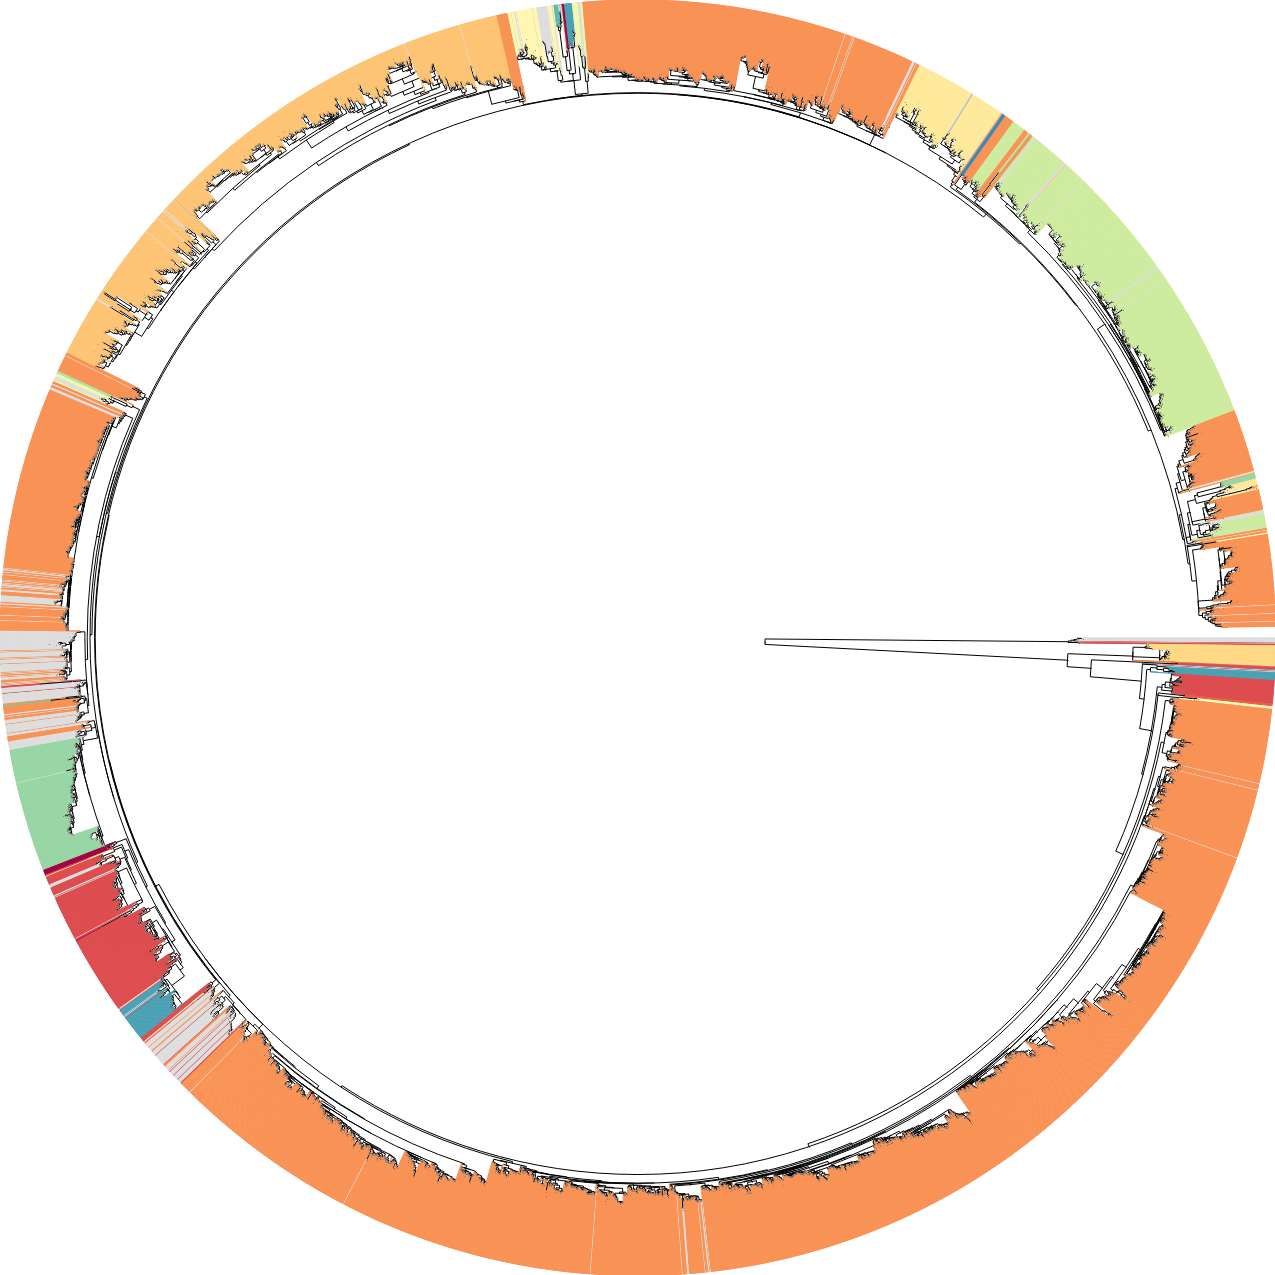

In [86]:
test_otu_tree = Tree(primate_denovo_tree_fp)

highlight_tree_phyla(test_otu_tree, taxa_dict, phylum_colors)

show filtered insertion tree and color by assigned phylum

In [87]:
primate_insertion_fp

'./phylogeny_constraint/data/primates.sepp.tre.qza'

In [88]:
primate_insertion_nwk_fp = join(data_dir, 'primates.sepp.tre')

In [327]:
!qiime tools export --input-path {primate_insertion_fp} \
--output-path {primate_insertion_nwk_fp} \
--output-format NewickFormat

Exported ./phylogeny_constraint/data/primates.sepp.tre.qza as NewickFormat to file ./phylogeny_constraint/data/primates.sepp.tre


In [89]:
primate_insert_tree = TreeNode.read(primate_insertion_nwk_fp)

primate_inserted_subtree = primate_insert_tree.shear(taxa_dict.keys())

primate_inserted_subtree_fp = join(data_dir, 'primates.sepp.subtree.tre')

primate_inserted_subtree.write(primate_inserted_subtree_fp)

'./phylogeny_constraint/data/primates.sepp.subtree.tre'

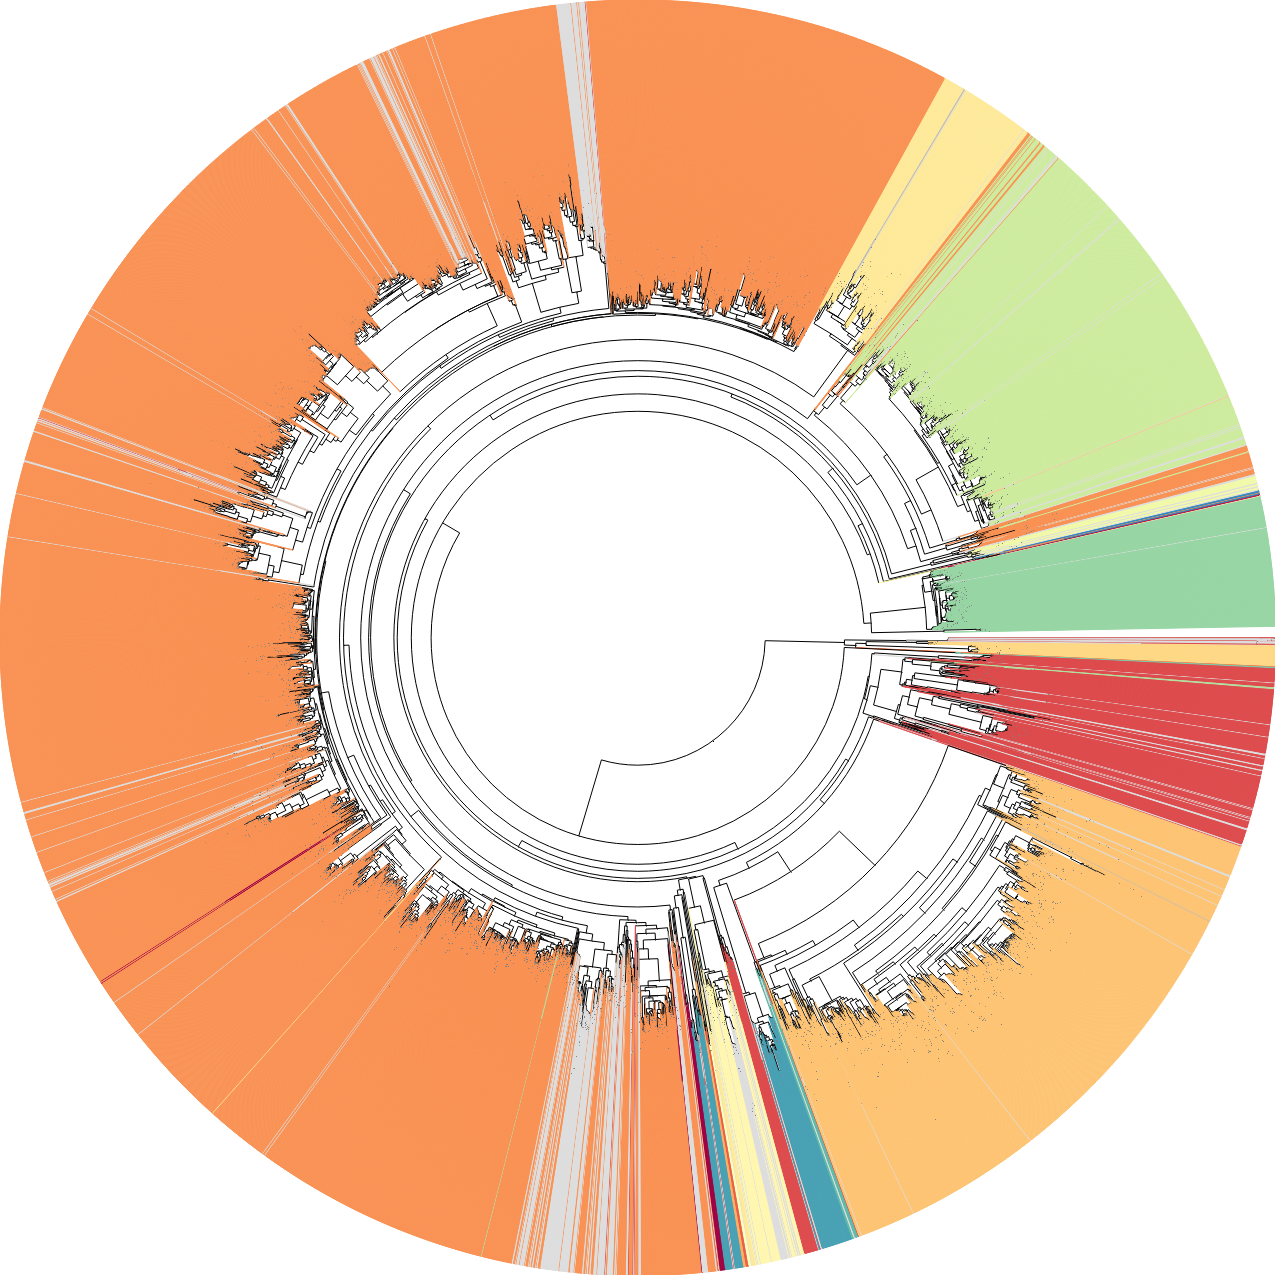

In [90]:
test_otu_tree = Tree(primate_inserted_subtree_fp, format=1, quoted_node_names=True)

highlight_tree_phyla(test_otu_tree, taxa_dict, phylum_colors)

### make constraint tree and rerun with constrained IQ-TREE

In [91]:
primate_constraint_tree = collapse_nodes_to_width(primate_inserted_subtree, max_width=0.2)
# primate_constraint_tree_nolen = remove_branch_lengths(primate_constraint_tree)

In [92]:
for node in primate_constraint_tree.postorder():
    node.length = None
    if not node.is_tip():
        node.name = None


In [119]:
primate_constraint_fp = join(data_dir, 'primates.sepp.subtree.constraint.tre')
primate_constraint_tree.write(primate_constraint_fp)

'./phylogeny_constraint/data/primates.sepp.subtree.constraint.tre'

In [120]:
tree_fp = primate_constraint_fp

In [121]:
with open(tree_fp,'r') as f:
        tree_str = f.readline()

In [129]:
tree_str = '(foo,bar);'

In [132]:
tree_str[1:-2]

'foo,bar'

In [128]:
os.path.splitext(tree_fp)

('./phylogeny_constraint/data/primates.sepp.subtree.constraint', '.tre')

In [ ]:
def unroot(tree_fp):
    with open(tree_fp,'r') as f:
        tree_str = f.readline()
    
    unrooted_fp = os.path.splitext(tree_fp)[0] + 'unrooted.tre'
    
    unrooted_str = '%s;' % tree_str[1:-2]
    
    with open(unrooted_fp, 'f') as f:
        f.write(unrooted_str)

In [112]:
TreeNode.read(primate_constraint_fp)

NewickFormatError: Could not parse file as newick. `(Parenthesis)`, `'single-quotes'`, `[comments]` may be unbalanced, or tree may be missing its root.

In [113]:
primate_constraint_tree.root()

<TreeNode, name: unnamed, internal node count: 2516, tips count: 6084>

Visualize constraint tree

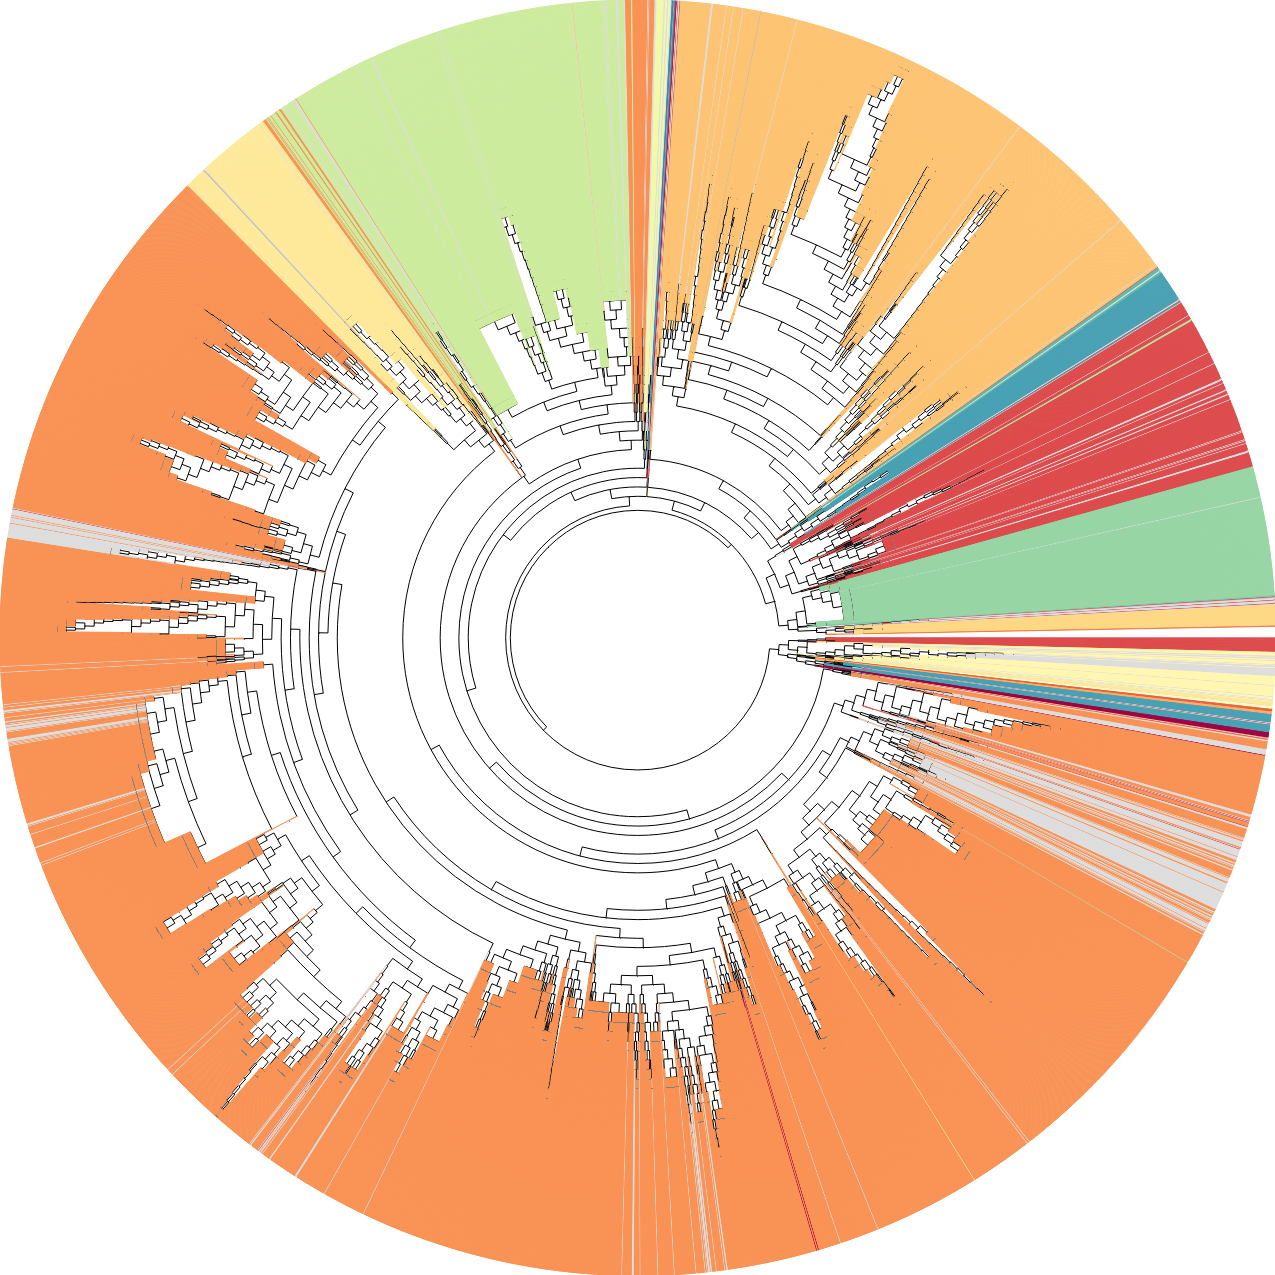

In [94]:
test_otu_tree = Tree(primate_constraint_fp, format=1, quoted_node_names=True)

highlight_tree_phyla(test_otu_tree, taxa_dict, phylum_colors)

In [118]:
# for running locally

# %%capture
# run IQ-TREE with constraints
!iqtree -nt 1 -s {primate_aln_fp} \
-m TIM2+I+G -g {primate_constraint_fp} \
-pre ./phylogeny_constraint/data/primates.sepp.subtree.constrained

IQ-TREE multicore version 1.5.5 for Mac OS X 64-bit built Feb  4 2018
Copyright (c) 2011-2017 by Bui Quang Minh, Nguyen Lam Tung,
Olga Chernomor, Heiko Schmidt, and Arndt von Haeseler.

Host:    Jons-MacBook-2.local (AVX2, FMA3, 8 GB RAM)
Command: iqtree -nt 1 -s ./phylogeny_constraint/data/primates.seqs.aln.fasta -m TIM2+I+G -g ./phylogeny_constraint/data/primates.sepp.subtree.constraint.tre -pre ./phylogeny_constraint/data/primates.sepp.subtree.constrained
Seed:    9045 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Wed Oct  3 12:25:33 2018
Kernel:  AVX+FMA - 1 threads (4 CPU cores detected)

Reading alignment file ./phylogeny_constraint/data/primates.seqs.aln.fasta ... Fasta format detected
Alignment most likely contains DNA/RNA sequences
Alignment has 6084 sequences with 264 columns and 212 patterns (162 informative sites, 80 constant sites)
                                                                                                                          

  79  TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCCCGTTAAGTCAGCGGTGAAATCTTGCGGCTCAACCGTGAGACTGCCGTTGAAACTGACGGGCTTGAGTGCGGCAGAGGTAGGCGGAATGTGTGG   43.18%    passed     63.16%
  80  TACGGAGACTGCAAGCGTTACTCGGAATTACTGGGCGTAAAGGGTGCGCAGGCGGCTAGGTATGTCAGATGTGAAAATGCGGGGCTTAACCCCGTAGCGCGTTTGAAACTACTTGGCTAGAGTTTTGGAGAGGTAAGTGGAATTTCTGGT   43.18%    passed     95.03%
  81  TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGCGTAGGCGGGTCGGCAAGTCAGATGTGAAATCCATGGGCTTAACCCATGAACTGCATTTGAAACTGTCGGTCTTGAGTGTCGGAGAGGCAAGCGGAATTCCGTG   43.18%    passed     94.69%
  82  TACGTAGGTGGCAAGCGTTATCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGACAGCAAGTCAGCGGTGAAATGTATGGGCTTAACCCATGAACTGCCGTTGAAACTGTTGTTCTTGAGTGGAGTAGAGGCAGGCGGAATTCCGGG   43.18%    passed     95.29%
  83  TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGACGGAAGAGCAAGTCTGATGTGAAAACCCGGGGCTTAACCCCGGGCCTGCATTGGAAACTGTTTTTCTGGAGTACTGGAAGGGCAAGCGGAATTCCTGG   43.18%    passed     91.28%
  84  TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGGTGGCAAG

1518  TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGTTTGTTAAGTCAGCGGTCAAATGTCGGGGCTCAACCCCGGCCTGCCGTTGAAACTGGCGAACTAGAGACGTATCGAGGCAGGCGGAATGCGAGGT   43.18%    passed     75.29%
1519  TACGTAGGGGGCGAGCGTTATCCGGATTCATTGGGCGTAAAGCGCGCGTAGGCGGCCTCGTAGGCCGGCGGGTCGAAGCTGGGGGCTCAACCCCCAGAAGCCCCCGGAACCCCGAGGCTTGGGTCCGGTAGGGGAGGGTGGAACGCCCGG   43.18%    failed      0.01%
1520  TACGTAGGTGGCGAGCGTTATCCGGAATTACTGGGCGTAAAGGGTGTGTAGGCGGGAAGACAAGTCAGATGTGAAAATTATGGGCTTAACCCATAACCTGCATTTGAAACTGTTTTTCTTGAGGATGGGAGAGGTAAATGGAATTCCCGG   43.18%    passed     61.70%
1521  TACGTATGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGCAAGGCAAGTCAGAAGTGAAAACCCGGGGCTCAACCCCGCGGATTGCTTTTGAGACTGTTTAGCTGGAGTGCAGGAGGGGCAAGCGGAATTCCTA   43.18%    passed     73.32%
1522  TACGTATGGTGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGCAGGCGGTGCGGCAAGTCTGATGTGAAAGCCCGGGGCTCAACCGCGGGACTGCATTGGAAACTGTCGTACTAGAGTGTCGGAGAGGTAAGTGGAATTCCTAG   43.18%    passed     91.65%
1523  TACGTAGGGAGCGAGCGTTATCCGGATTTATTGGGTGTAAAGGGCGCGTAGACGGTTTA

2999  TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGCAGCCGGGTCAGCAAGTCAGATGTGAAATCCATGGGCTTAACCCATGAACTGCATTTGAAACTGCCGATCTTGAGTGTCGGAGGGGCAATCGGAATTCCTAG   43.18%    passed     88.55%
3000  TACGTAGGGAGCAAGCGTTATCCGGATTTATTGGGCGTAAAGGGTGCGTAGGCGGCTTGTTAAGTATGAGATTAAAGCCCGAGGCTTAACCTCGGTTCGTTTCATAAACTGGCAGGCTTGAGTGTGGCAGAGGTAAACGGAATTTCTAGT   43.18%    passed     71.08%
3001  TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGCCGGGCCTTTAAGTCAGATGTGAAATCCGCGGGCTTAACCCGCGAACTGCATTTGAAACTGAGGGTCTTGAGTATCGGAGAGGTAACCGGAATTCCTAG   43.18%    passed     92.03%
3002  TACGTAGGGGACGAGCGTTATCCGGATTTATTGGGCGTAAAGCGTGCGTAGGCGGCATATTAAGTTTAAGATAAAAGCCCGGGGCTCAACTCCGGTTCGTCTTAAAAACTGATAAGCTTGAGTGTGGTAGAGGTAAATGGAATTTCTAGT   43.18%    passed     46.68%
3003  TACGTAGGGGGCGAGCGTTATCCGGATTTATTGGGCGTAAAGCGTGTGTAGGCGGTTTGTTAAGTATAAGATTAAAGCCCGGGGCTCAACTCCGGTTCGTCTTATAAACTGGCAGGCTTGAGTGTGGTAGAGGCAAGTGGAATTTCTAGT   43.18%    passed     47.79%
3004  TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAG

4347  TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTTCTTTAAGCGTGTTGTGAAATACTGCCGCTCAACGGCAGAGGTGCAGCGCGAACTGGAGGACTTGAGTGCGTGGAACGTGGGCGGAATTCGTCG   43.18%    passed     70.33%
4348  AACGTAGGTCACAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAGTACAAGTTGGAAGTGAAATCCATGGGCTCAACCCATGAACTGCTTTCAAAACTGTATTTCTTGAGTAGTGCAGAGGTAGGCGGAATTCCCGG   43.18%    passed     84.21%
4349  TACAGAGGGTGCAAGCGTTAATCGGATTTACTGGGCGTAAAGCGCGCGTAGGCGGCTAATTAAGTCAAATGTGAAATCCCCGAGCTTAACTTGGGAATTGCATTCGATACTGGTTAGCTAGAGTGTGGGAGAGGATGGTAGAATTCCAGG   43.18%    passed     81.80%
4350  TACGTAGGGAGCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGCGGCGATGCAAGTCAGGCGTGAAATGCAGAGGCTTAACCTCTGACGTGCGTTTGAAACTGTGTTGCTTGAGTGAAGTAGAGGCAGGCGGAATTCCCGG   43.18%    passed     80.92%
4351  TACGTAGGTCCCGAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAGCGCAGGCGGTTAGATAAGTCTGAAGTTAAAGGCTGTGGCTTAACCATAGTACGCTTTGGAAACTGTTTAACTTGAGTGCAAGAGGGGAGAGTGGAATTCCATGT   43.18%    passed     77.71%
4352  CACGGGGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGCGCGTAGGCGGGACG

5467  TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGCAGGCGGTCGTGCAAGTCAGTCGTCAAATTGCCCGGCTCAACCGGGTACCGCGGTTGAAACTGCATGACTTGGGTGCACAAGAGGCAGGCGGAACTCGTGGT   43.18%    passed     45.76%
5468  TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGCAGGCGGCGTTTCAAGTCAGCGGTCAAATCTCCGGGCTCAACCCGGTTCCGCCGTTGATACTGTTGCGCTCGAGTGCGGGCGAGGAGAGCGGAATGCGTCAT   43.18%    passed     22.60%
5469  TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTCGGTTAAGCGTGTTGTGAAATGTAGTTGCTCAACATCTGCACTGCAGCGCGAACTGGCCGACTTGAGTACGCACAACGTGGGCGGAATTCGTGG   43.18%    passed     74.93%
5470  TACGGAAGGTCCGGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGGAGGTTAAGCGTGTTGTGAAATGTAGGCGCTCAACGTCTGCACTGCAGCGCGAACTGGCTTTCTTGAGTACGCACAACGTGGGCGGAATTCGTGG   43.18%    passed     70.94%
5471  TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCTGGTTTTTAAGCGTGTTGTGAAATGTAGACGCTCAACGTCTGCACTGCAGCGCGAACTGGAAGCCTTGAGTACGGTGGAAGTAGGCGGAATTCGTTG   43.18%    passed     80.01%
5472  TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGTGGCCTT

Creating fast initial parsimony tree by random order stepwise addition...
^C


In [ ]:
# for running on remote Torque server

script = ('cd /home/jgsanders/git_sw/q2-fragment-insertion; '
          'iqtree -nt 16 -s {primate_aln_fp} '
          '-m TIM2+I+G -g {primate_constraint_fp} '
          '-pre ./phylogeny_constraint/data/primates.sepp.subtree.constrained'.format(
            primate_aln_fp=primate_aln_fp,
            primate_constraint_fp=primate_constraint_fp))

qsub(script, environment='source activate qiime2-2018.6',
         mem=32, n=16, t='24:00:00', name='nb_iqtree',
         o='./iqtree_const_primates.out', e='./iqtree_const_primates.err')

We can see that we have now recovered substantial structure within our group of sequences

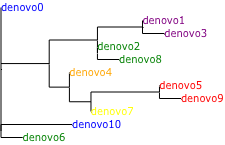

In [211]:
highlight_tree(Tree(join(data_dir, 'test_sequences.sepp.subtree.only.constrained.treefile')), leaf_colors)

show filtered constrained de novo tree

grab some specific codiversifying clades and see how they fared in each 